# Sugarcane Time-Since-Harvest Tool

Text(value='', description='Address', layout=Layout(width='100%'))

Dropdown(description='Snapshot Date:', index=70, options=('2016-12-22', '2017-01-01', '2017-01-11', '2017-02-1…

Output(layout=Layout(border='1px solid black'))

<IPython.core.display.Javascript object>


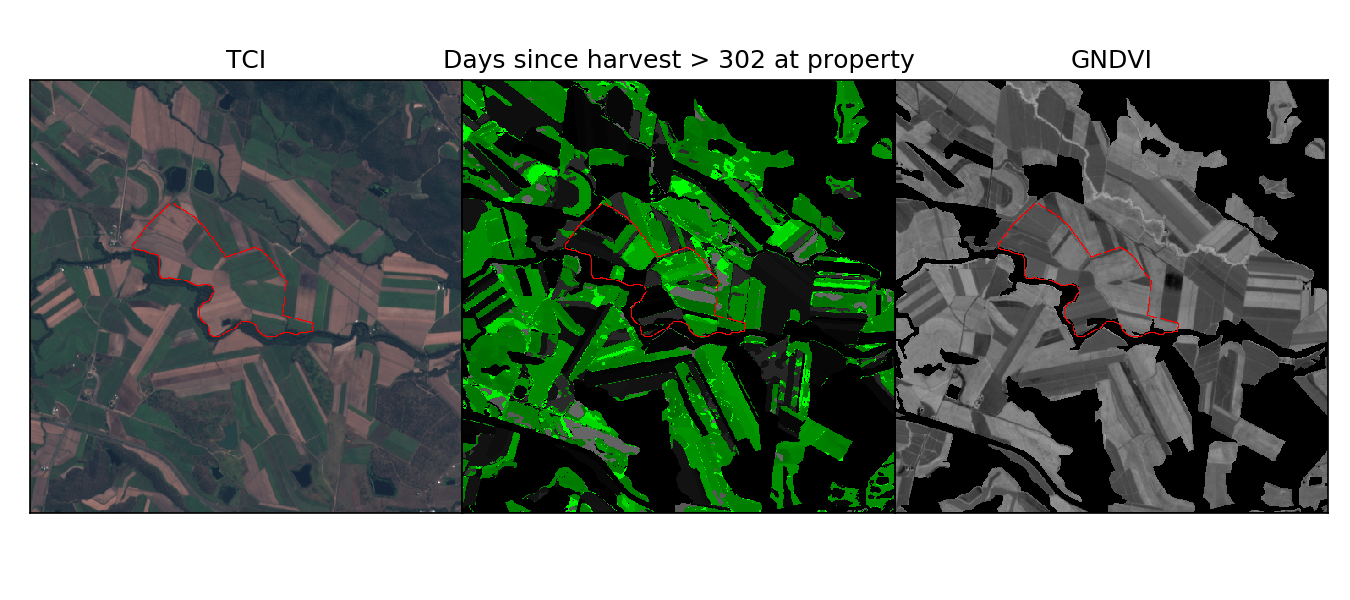

In [2]:
# Prompt for Address (e.g. 20 Halliwells Rd, Yalboroo 4770) or Coordinates (e.g. -20.8372178,148.7324626)

# SETUP/CODE

# Import required modules and load tile geometries
import locale
import sys
import os
import glob
import ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
%matplotlib notebook

from PIL import Image

locale.setlocale(locale.LC_ALL, 'en_US')

# Suppress ugly warning generated by s2cloudless
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Make sure local modules can be imported
module_path_root = os.path.abspath(os.path.join(os.pardir, os.pardir))
module_path = os.path.join(module_path_root, "Satellite")
if module_path not in sys.path:
    sys.path.append(module_path)

# Import local modules
import Contrib.addressGeocode as geocode
import sentinel.farm          as farm
import sentinel.geometry_list as geometry_list
from sentinel.tilesnapshot import tilesnapshot

# Set current directory to where "data" is, if not done already
try:
    data_path
except NameError:
    import configparser
    config = configparser.ConfigParser()
    config.read('jupyter_satellites.config')
    data_path = config.get('Jupyter_Notebooks', 'data_path')
    os.chdir(data_path)
    
# Load tile geometry data
gl = geometry_list("geometries")


# This function is called when someone submits an address
# It geocodes the address, then sets up the other widgets and images
def handle_geocode_submit(sender):
    global f
    f = farm.farm(address.value, gl)
    
    # If we couldn't find the address, then print an error message and leave
    if (f.tile_x == "N/A"):
        print("Unable to find address: " + address.value)
        return
    
    # Find the boundary of this property, using cached information if it's already been worked out
    f.img = f.getBoundary()
    if (f.img == "N/A"):
        print("Unable to find boundaries for this property")
    
    # If we found the tile (f.tile_x != "N/A") but we didn't find the shape of the property,
    # we'll continue and do the best we can

    # Declare a global variable to store the date of the snapshot being displayed.
    # By default, use the latest snapshot
    global g_dateStr
    g_dateStr = max(f.dates)

    # Create a snapshot "date" dropdown list
    global datepick
    datepick = widgets.Dropdown(
        options     = f.dates,
        value       = g_dateStr,
        description = 'Snapshot Date:',
        disabled    = False
    )
    
    # Register the function that will handle input from the date picker, and display it on screen
    datepick.observe(handle_date_submit)   
    display(datepick)
    
        
    # Declare a global variable to store the desired threshold "days since last harvest"
    # If a pixel appears to have been harvested before, and it's more than this number of
    # days since it was last harvested, then we assume it's potentially ready to be harvested now
    # Default 365
    global g_days_threshold_int
    g_days_threshold_int = 365
    
    # Create a slider to allow the user to specify the threshold
    global days_threshold
    days_threshold = widgets.IntSlider(
        min         = 0,
        max         = 750,
        value       = g_days_threshold_int,
        description = 'Threshold days since last harvest:',
        disabled    = False
    )

    # Register the function that will handle input from the threshold slider
    # Don't display it on screen yet, we're going to group it with something else in the layout
    days_threshold.observe(handle_threshold_submit)

    # Declare a global variable to store the assumted yield (TCI)
    global g_assumed_yield_factor
    g_assumed_yield_factor = 96  # based on a paper and its figures Proserpine, one year
    
    # Create a slider to allow the user to specify the yield
    global yield_slider
    yield_slider = widgets.IntSlider(
        ming        = 0,
        max         = 250,
        value       = g_assumed_yield_factor,
        description = 'Yield assumed (TCH)',
        disabled    = False
    )
    
    # Register the function that will handle input from the threshold slider
    # Don't display it yet
    yield_slider.observe(handle_yield_submit)
    
    # Create a button to refresh the data after changing the date/threshold/yield estimate
    global refresh_button
    refresh_button = widgets.Button(
        description  = "Refresh",
        disabled     = False,
        button_style = "",
        tooltip      = "Refresh"
    )

    # Register the function that will handle input from the threshold slider
    # But don't display it yet...
    # This button directly calls the main update_images() function
    
    refresh_button.on_click(update_images)

    # Create a "box" to collect the controls together horizontally
    global neat_box
    neat_box = widgets.HBox([days_threshold, yield_slider, refresh_button])
    
    # NOW display those controls, laid out nicely
    display(neat_box)

    # Create an "output box" that can display messages about statistics we calculate,
    # above any images, but below the other controls
    global output_box
    output_box = widgets.Output(layout={'border': '1px solid black'})
    display(output_box)
    
    # Start working on loading those images!
    # We are using lots of global variables so that the event handler functions
    # can refer to them when they need to take action
    
    # Matplotlib objects for a 2x1 layout
    global fig
    global spec
    global ax1
    global ax2
    global ax3
    fig = plt.figure(figsize=(9, 4))
    spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig)
    spec.update(wspace=0.0, hspace=0.0)
    ax1 = fig.add_subplot(spec[0, 0])
    ax2 = fig.add_subplot(spec[0, 1])
    ax3 = fig.add_subplot(spec[0, 2])

    # Supress any ugly axis tick marks around the images
    for ax in [ax1, ax2, ax3]:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    # Pack the images reasonably tightly together, don't waste so much space
    fig.tight_layout()

    # Call a separate method to update the images on display, with whatever the
    # latest global selections are
    # This method has to take one argument, so that it can be used directly as
    # an event handler, but the argument doesn't really do anything, so we just
    # give it a "0"
    update_images(0)
           

# This function handles a date change
# If we change to a different value, we set the global varible to represent
# the new selected date, then update any images and statistics immediately
def handle_date_submit(change):
    if ((change['type'] == 'change') and (change['name'] == 'value')):
        global g_dateStr
        g_dateStr = change['new']
        
        update_images(0)

        
# This function handles a change to the threshold on the slider
# We don't immediately recalculate, otherwise we'd be doing that for every little
# movement in the slider!  We wait until the "refresh" button is hit
def handle_threshold_submit(change):
    global g_days_threshold_int
    if ((change['type'] == 'change') and (change['name'] == 'value')):
        g_days_threshold_int = change['new']

        
# This function handles a change to the assumed yield slider
def handle_yield_submit(change):
    global g_assumed_yield_factor
    if ((change['type'] == 'change') and (change['name'] == 'value')):
        g_assumed_yield_factor = change['new']
        
        
# This function will create an image showing the number of days since the last
# harvest, for each pixel.
# It is called by the overall update_images() function when we want to refresh/display
# the selected data
def threshold_days_since_harvest(tile_x, tile_y, dateStr, threshold, size_x=512, size_y=512):
    # Open the relevant tilesnapshot layer for reading
    ts = tilesnapshot(tile_x, tile_y, dateStr, size_x, size_y)
    ts.loadDaysSinceHarvest()
    
    # Initialise an output image and statistics
    img_threshold = Image.new('RGB', (size_x, size_y))
    
    count_black = 0
    count_raw   = 0
    count_ripe  = 0
    
    for y in range(size_y):
        for x in range(size_x):
            current_value = ts.layers['DaysSinceHarvest'][y,x]
            
            # Because we could easily be more than 255 days since harvest,
            # we scaled it into a monochrome image that goes up to 65535,
            # where 65535 is reserved for "never been harvested".
            
            # We now want to turn it back into RGB colour, where the pixels
            # go up to 255
            approx_value = round(current_value * 255 / 65535)
            
            if (current_value == 65535):
                # Never harvested -> paint it black
                img_threshold.putpixel((y, x), (0, 0, 0))
                count_black += 1
            elif (current_value < (threshold * 90)):
                # Under-ripe -> make it grey, R=G=B
                img_threshold.putpixel((y, x), (approx_value, approx_value, approx_value))
                count_raw += 1
            else:
                # Ripe -> make it green.  Intensity is still an indicator of how long since harvest
                img_threshold.putpixel((y, x), (0, approx_value, 0))
                count_ripe += 1
    
    # Return both the image (held in memory) and a count of how many pixels are ready at the tile level
    return img_threshold, count_ripe


# This function will create a version of the "days since harvest with threshold" image,
# but with the outline of the selected farm/property highlighted.
# It will also count how many pixels are within the property, and how many are
# above the threshold
def overlay_farm_on_harvest(img_harvest, img_farm, size_x=512, size_y=512):
    if (img_farm == "N/A"):
        return "N/A", 0, 0
    
    # Make a copy of the tile-level image of pixels ready for harvest
    img_farm_threshold = img_harvest.copy()
    
    # Initialise statistics about the farm/property
    count_farm_ripe  = 0
    count_farm_total = 0
    
    for y in range(size_y):
        for x in range(size_x):
            farm_pixel = img_farm.getpixel((y, x))
            if (farm_pixel == (255, 0, 0, 255)):
                # This pixel is the boundary of the property, drawn just outside
                # of all the pixels that are within the boundary.  Raw a red line
                # so that you can see it
                # But it doesn't count as part of the property itself, for statistics purposes
                img_farm_threshold.putpixel((y, x), (255, 0, 0, 255))
            elif (farm_pixel == (0, 0, 255, 255)):
                # This pixel is part of the property
                # Count it as a pixel belonging to the property
                count_farm_total += 1
                orig_pixel = img_harvest.getpixel((y, x))
                if (orig_pixel[1] > orig_pixel[0]):
                    # If the original harvest image says it's above the threshold, count it as ripe
                    # Keep it in that green colour, though
                    count_farm_ripe += 1
    
    # Return the image (with property boundary drawn in red) plus the farm-level statisitcs
    return img_farm_threshold, count_farm_ripe, count_farm_total
    

# This function will overlay the farm boundary line on the TCI image, if the boundary was found
def overlay_farm_on_tci(img_tci, img_farm, size_x=512, size_y=512):
    if (img_farm == "N/A"):
        return "N/A"
    
    # Make a copy of the TCI image
    img_tci_farm = img_tci.copy()
    
    for y in range(size_y):
        for x in range(size_x):
            farm_pixel = img_farm.getpixel((y, x))
            if (farm_pixel == (255, 0, 0, 255)):
                # This pixel is the boundary of the property, draw it
                img_tci_farm.putpixel((y, x), (255, 0, 0, 255))
                
    return img_tci_farm


# This function will overlay the farm boundary line on the GNDVI image, if the boundary was found
def overlay_farm_on_gndvi(img_gndvi, img_farm, size_x=512, size_y=512):
    if (img_farm == "N/A"):
        img_gndvi_plain = Image.new('RGBA', (size_x, size_y))
        
        for y in range(size_y):
            for x in range(size_x):
                gndvi_pixel = img_gndvi.getpixel((y, x))
                img_gndvi_plain.putpixel((y, x), (gndvi_pixel[0], gndvi_pixel[0], gndvi_pixel[0], 255))

        return img_gndvi_plain, 0, 0
    
    # Make a copy of the TCI image
    img_gndvi_farm = Image.new('RGBA', (size_x, size_y))
    
    total_gndvi = 0
    count_gndvi = 0
    max_gndvi   = 0
    
    for y in range(size_y):
        for x in range(size_x):
            farm_pixel = img_farm.getpixel((y, x))
            if (farm_pixel == (255, 0, 0, 255)):
                # This pixel is the boundary of the property, draw it
                img_gndvi_farm.putpixel((y, x), (255, 0, 0, 255))
            else:
                gndvi_pixel = img_gndvi.getpixel((y, x))
                img_gndvi_farm.putpixel((y, x), (gndvi_pixel[0], gndvi_pixel[0], gndvi_pixel[0], 255))
                count_gndvi += 1
                total_gndvi += gndvi_pixel[0] / 255
                if (gndvi_pixel[0] / 255 > max_gndvi):
                    max_gndvi = gndvi_pixel[0] / 255
                
    if (count_gndvi > 0):
        mean_gndvi = total_gndvi / count_gndvi
    else:
        mean_gndvi = 0
        
                
    return img_gndvi_farm, mean_gndvi, max_gndvi


# This is the main function to update all images and statistics, for the latest selections
def update_images(fake):
    # The argument "fake" is just there to keep the ipywidgets framework happy about
    # directly using this function as an event handler for a "refresh" button
    # We don't actually use the argument, because all our selections are managed via
    # global variables
    
    tci_file = os.path.join("sugarcanetiles", f.tile_x + "-" + f.tile_y + "-" + "TCI" + "-" + g_dateStr + ".png")
    #tci_img  = mpimg.imread(tci_file)
    tci_img = Image.open(tci_file)
    
    # Create a version of the TCI file where the farm border is overlaid, if available
    tci_img_overlay = overlay_farm_on_tci(tci_img, f.img)
    
    # Create an initial image of pixels ready for harvest, at a tile level
    harvest_file = os.path.join("masks", "harvested", "mask-x" + f.tile_x + "-y" + f.tile_y + "-" + g_dateStr + ".png")
    harvest_img  = mpimg.imread(harvest_file)
    
    days_file = os.path.join("masks", "days_since_harvest_8bit", "mask-x" + f.tile_x + "-y" + f.tile_y + "-" + g_dateStr + ".png")
    days_img  = mpimg.imread(days_file)
    
    gndvi_file = os.path.join("masks", "gnvdi_intensity", "mask-x" + f.tile_x + "-y" + f.tile_y + "-" + g_dateStr + ".png")
    gndvi_img  = Image.open(gndvi_file)
    
    img_threshold, count_ripe = threshold_days_since_harvest(tile_x=f.tile_x, tile_y=f.tile_y, dateStr=g_dateStr, threshold=g_days_threshold_int)
    
    # Overlay the farm onto the harvest image
    img_farm_threshold, count_farm_ripe, count_farm_total = overlay_farm_on_harvest(img_threshold, f.img)
    
    # Overlay the farm onto the gndvi image
    img_gndvi_overlay, mean_gndvi, max_gndvi = overlay_farm_on_gndvi(gndvi_img, f.img)
        
    ax1.clear()
    if (f.img != "N/A"):
        ax1.imshow(tci_img_overlay)
    else:
        ax1.imshow(tci_img)
    ax1.set_title('TCI')

    ax2.clear()
    if (img_farm_threshold != "N/A"):
        ax2.set_title('Days since harvest > ' + str(g_days_threshold_int) + ' at property')
        ax2.imshow(img_farm_threshold)
    else:
        ax2.set_title('Days since harvest > ' + str(g_days_threshold_int))
        ax2.imshow(img_threshold)
    
    ax3.clear()
    ax3.imshow(img_gndvi_overlay)
    ax3.set_title('GNDVI')
    
    plt.show()
    
    output_box.clear_output(wait=False)
    output_box.append_stdout('Threshold:                     ' + str(g_days_threshold_int) + "\n")
    output_box.clear_output(wait=False) 
    output_box.append_stdout('Tile pixels above threshold:   ' + locale.format_string("%d", count_ripe, grouping=True) + "\n")
    output_box.append_stdout('Farm pixels:                   ' + locale.format_string("%d", count_farm_total, grouping=True) + "\n")
    output_box.append_stdout('Farm pixels above threshold:   ' + locale.format_string("%d", count_farm_ripe, grouping=True) + "\n")
    output_box.append_stdout('Farm hectares:                 ' + locale.format_string("%d", count_farm_total / 1000, grouping=True) + "\n")
    output_box.append_stdout('Farm hectares above threshold: ' + locale.format_string("%d", count_farm_ripe / 1000, grouping=True) + "\n")
    output_box.append_stdout('Assumed yield (TCH):           ' + locale.format_string("%d", g_assumed_yield_factor, grouping=True) + "\n")
    
    estimated_yield = g_assumed_yield_factor / 1000 * count_farm_ripe
    
    output_box.append_stdout('Estimated farm yield (tonnes): ' + locale.format_string("%f", estimated_yield, grouping=True) + "\n")
    
    # Not as useful as I expected, some farms have fields that stay green and unharvested
    #output_box.append_stdout('Farm mean GNDVI:             ' + locale.format_string("%f", mean_gndvi, grouping=True) + "\n")
    #output_box.append_stdout('Farm max. GNDVI:             ' + locale.format_string("%f", max_gndvi, grouping=True) + "\n")
    
    
# GUI

# Display text box for address entry
address=widgets.Text(
    description='Address',
    layout=widgets.Layout(width='100%')
)

address.on_submit(handle_geocode_submit)
display(address)